In [1]:
%%capture
!pip install --upgrade einops optax equinox distrax jaxopt

In [2]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import gelu, sigmoid
from jax import disable_jit
from jaxopt import FixedPointIteration
from jax.tree_util import tree_map

import numpy as np

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)

import copy

In [3]:
def multi_batch_loss(model_alpha, A, w, keys) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i:
    models, prime_x_arrays, prime_labels = eqx.filter_vmap(task_update,in_axes=(None,0,0,0))(model_alpha, A, w, keys)
    # sum loss_i(model_i', test_i, test_labels_i)
    return eqx.filter_vmap(batch_loss)(models, prime_x_arrays, prime_labels).sum()

In [4]:
def batch_loss(model, x_arr: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(x: Array, label: Array):
        # -> (model(x)-Asin(x+w))^2
        pred = model(jnp.array([x]))
        return (pred-label)**2

    # Mean over the batch
    return vmap(loss)(x_arr, labels).mean()

In [5]:
def get_batch_of_tasks(N: int, key: PRNGKeyArray):
    # batch of size N
    # a task is given by amplitute A and phase w 
    A_key, w_key = split(key)
    A = random.uniform(A_key, shape=(N,),minval=0.1, maxval=5.0)
    w = random.uniform(w_key, shape=(N,),minval=0.0, maxval=jnp.pi)
    return A,w

In [6]:
def sample_from_task(A: float, w: float, N: int, key: PRNGKeyArray):
    # sample N examples from task
    # -> training data: train, train_labels both of size N

    # Task T(A,w): A in [0.1, 5.0], w in [0, pi]

    # Load the dataset

    train = random.uniform(key,minval=-5.0, maxval=5.0,shape=(N,))
    train_labels = A*jnp.sin(train+w)
    return train, train_labels 

In [7]:
# Training step function
#@eqx.filter_jit
def step(model, alpha, optimizer, opt_state, x_arr, labels):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, x_arr, labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, alpha)  # replace standard gradient with alpha*gradient (elementwise product)
    updates, opt_state = optimizer.update(mod_grad, opt_state, model)  
    model = eqx.apply_updates(model, updates)  
    return model, opt_state, loss

In [16]:
epochs = 60000
model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
alpha = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY, activation=None, final_activation=None)
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*(x/x), alpha)
beta = 0.0001  # outer loop LR, constant

In [17]:
meta_sgd_batch_size = 4
K = 5
Kprime = 10
#outer_optim = adam(1e-3, eps=1e-04)
outer_optim = sgd(beta)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  # Does it matter how we initialize the state of the optimizer? 


def task_update(model_alpha, A: Array, w: Array, key: PRNGKeyArray):

    train_key, val_key = split(key)
    train, train_labels = sample_from_task(A, w, K, train_key)  # get train_i and train_labels_i

    # inner loop
    inner_optim = sgd(1)  # LR = 1 since the 'real' learning rate is included in alpha (see fcn step(...))
    model, alpha = copy.deepcopy(model_alpha[0]), model_alpha[1]  # dont want to change the outer model
    inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

    model, inner_opt_state, inner_loss = step(model, alpha, inner_optim, inner_opt_state, train, train_labels)  # compute model_i'

    train_prime, train_labels_prime = sample_from_task(A, w, Kprime,val_key)  # get test_i and test_labels_i
    return model, train_prime, train_labels_prime

@eqx.filter_jit
def maml_step(model, alpha, outer_opt_state, key: PRNGKeyArray):
    # Sample tasks for task(list)
    keys = split(key,meta_sgd_batch_size)
    A, w = get_batch_of_tasks(meta_sgd_batch_size, key)
  
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)((model, alpha), A, w, keys)  # Compute loss and gradient, meta step

    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, (model, alpha))  
    (model, alpha) = eqx.apply_updates((model, alpha), updates)  

    return loss, model, alpha, outer_opt_state

In [18]:
# Meta train the model
pbar = tqdm(random.split(MODEL_KEY,epochs),total=epochs)
for key in pbar:
    loss, model, alpha, outer_opt_state = maml_step(model, alpha, outer_opt_state, key)  # = filter_jit(step)(model, opt_state)
    pbar.set_postfix({'loss': f'{loss.mean():.3}'})


  0%|          | 0/60000 [00:00<?, ?it/s]

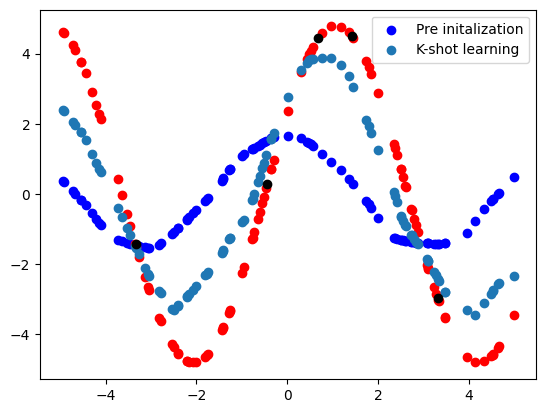

In [12]:
import matplotlib.pyplot as plt
test, test_labels = sample_from_task(jnp.array(4.8), jnp.array(0.5), 100, TEST_KEY)
train_test, train_test_labels = sample_from_task(jnp.array(4.8), jnp.array(0.5),5, TEST_KEY)
preds_initial = eqx.filter_vmap(model)(jnp.expand_dims(test,1))

plt.scatter(test, preds_initial, color='blue', label="Pre initalization")
plt.scatter(test, test_labels, color='red')

#inner_optim = adam(1e-2, eps=1e-04)
inner_optim = sgd(1)  # LR = 1 since the 'real' learning rate is included in alpha
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

trainable_model = copy.deepcopy(model)
final_alpha = copy.deepcopy(alpha)
for i in range(1):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(trainable_model, train_test, train_test_labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, final_alpha)
    updates, inner_opt_state = inner_optim.update(mod_grad, inner_opt_state, trainable_model) 
    trainable_model = eqx.apply_updates(trainable_model, updates) 

preds_shot = eqx.filter_vmap(trainable_model)(jnp.expand_dims(test,1))
plt.scatter(test, preds_shot, label="K-shot learning")
plt.scatter(train_test, train_test_labels, color='black')
plt.legend()
plt.show()